## Manpreet Misson

Information: Chat GPT was used in some parts of the notebook, but this was explicitly mentioned in the relevant sections. In addition, the documentation was further optimised with the help of AI.

### Life Expectancy - Regression with Neural Network 

This project focuses on predicting life expectancy using a regression approach with a neural network. Dataset - Link: https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who

### Importing Required Libraries
In this step, all necessary Python libraries are imported to support all data processes for this analysis.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from skfeature.function.similarity_based import fisher_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import tkinter as tk
from tkinter import messagebox
import keras
from keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
import country_converter as coco


### Loading and Inspection the Dataset
The dataset Life Expectancy Data.csv is loaded into a DataFrame, and column names are stripped of extra spaces to avoid errors. The target variable "Life expectancy" is selected with a conditional check to handle naming inconsistencies.

In [ ]:
df = pd.read_csv("Life Expectancy Data.csv")
df.columns = df.columns.str.strip()
target = "Life expectancy" if "Life expectancy" in df.columns else "Life expectancy "
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


### Mapping Countries to Continents
The country converter library was used to automatically map each country to its continent, because only numeric metrics are allowed.

Here GPT recommended using coco, because this avoids manually placing every country into arrays for each continent. However, since coco only returns America as a single category, an extra step was required to split it into North America and South America for a more detailed analysis.

In [ ]:
df["Continent"] = coco.convert(names=df["Country"], to="continent")
south_america = {
    "Argentina","Bolivia (Plurinational State of)","Brazil","Chile","Colombia",
    "Ecuador","Guyana","Paraguay","Peru","Suriname","Uruguay",
    "Venezuela (Bolivarian Republic of)"
}
df["Continent"] = df.apply(
    lambda r: "South America" if r["Continent"]=="America" and r["Country"] in south_america
              else ("North America" if r["Continent"]=="America" else r["Continent"]),
    axis=1
)

### Handling Missing Values
Numeric columns (except the target) were selected for imputation. Missing values were first filled with the median of each continent group, so that regional patterns were protected (e.g., African countries are compared only with other African countries). If gaps still remained after this step, they were filled with the global median of the column, ensuring that no missing values were left. Rows without the target variable were dropped, since they cannot be used for training. At this step, GPT was used to optimize the code. The reason for this was to speed up the workflow and avoid repetitive manual coding, while correctness was verified by checking that no missing values remained after imputation.

In [ ]:
num_cols = df.select_dtypes(include=[np.number]).columns.difference([target])
df[num_cols] = df.groupby("Continent")[num_cols].transform(lambda s: s.fillna(s.median()))
df[num_cols] = df[num_cols].fillna(df[num_cols].median())
df = df.dropna(subset=[target])

### Removing Duplicates
The dataset is checked for duplicate rows and any duplicates are removed before resetting the index.

In [ ]:
print("Numbers of duplicates:", df.duplicated().sum())
df = df.drop_duplicates().reset_index(drop=True)

Numbers of duplicates: 0


### Encoding Categorical Features
The continent column was converted into dummy variables. In addition, the country status was mapped to numeric values (0 = Developing, 1 = Developed). After the encoding, the original categorical columns were dropped since their information was now represented in numeric form. At this step, GPT was used to optimize the code. The reason for this was to speed up the workflow and avoid repetitive manual coding.

In [ ]:
df = pd.concat([df, pd.get_dummies(df["Continent"]).astype(int)], axis=1)
df["Country_Status"] = df["Status"].map({"Developing": 0, "Developed": 1})
df = df.drop(columns=["Country", "Continent", "Status"])

### Final Missing Value Check
The total number of missing values in the dataset is printed to confirm that all gaps have been handled.

In [ ]:
print("Total missing values:", int(df.isna().sum().sum()))

Total missing values: 0


### Feature and Target Split
The dataset is divided into features (X) and the target variable (y), where the target is life expectancy.

In [ ]:
X = df.drop(columns=[target])
y = df[target]

### Correlation Analysis
The correlation matrix shows that Schooling (0.75), Income composition of resources (0.72), and BMI (0.57) are most positively related to life expectancy, while Africa (-0.72), Adult Mortality (-0.70) and HIV/AIDS (-0.56) show the strongest negative correlations. 

This code for the correlation matrix was used from the teaching notebook

In [ ]:
correlations = df.corr(numeric_only=True) 
correlations["Life expectancy"].sort_values(ascending=False)

Life expectancy                    1.000000
Schooling                          0.746812
Income composition of resources    0.724901
BMI                                0.571349
Country_Status                     0.482136
Diphtheria                         0.477254
Polio                              0.463749
Europe                             0.448480
GDP                                0.444740
Alcohol                            0.412930
percentage expenditure             0.381864
Hepatitis B                        0.226187
Total expenditure                  0.223541
North America                      0.172187
Year                               0.170033
Asia                               0.121605
South America                      0.104239
Oceania                            0.050231
Population                        -0.029180
Measles                           -0.157586
infant deaths                     -0.196557
under-five deaths                 -0.222529
thinness 5-9 years              

### Correlation Heatmap
The heatmap shows that life expectancy is strongly positively related to Schooling, Income composition of resources, and BMI, while it shows strong negative correlations with Adult Mortality, HIV/AIDS, and Africa. This visual representation makes it much easier to identify both positive (red) and negative (blue) relationships at a glance. 

GPT suggested creating this heatmap, since it provides a quick way to explore all correlations in the dataset without having to inspect values in a table, making important patterns visible.

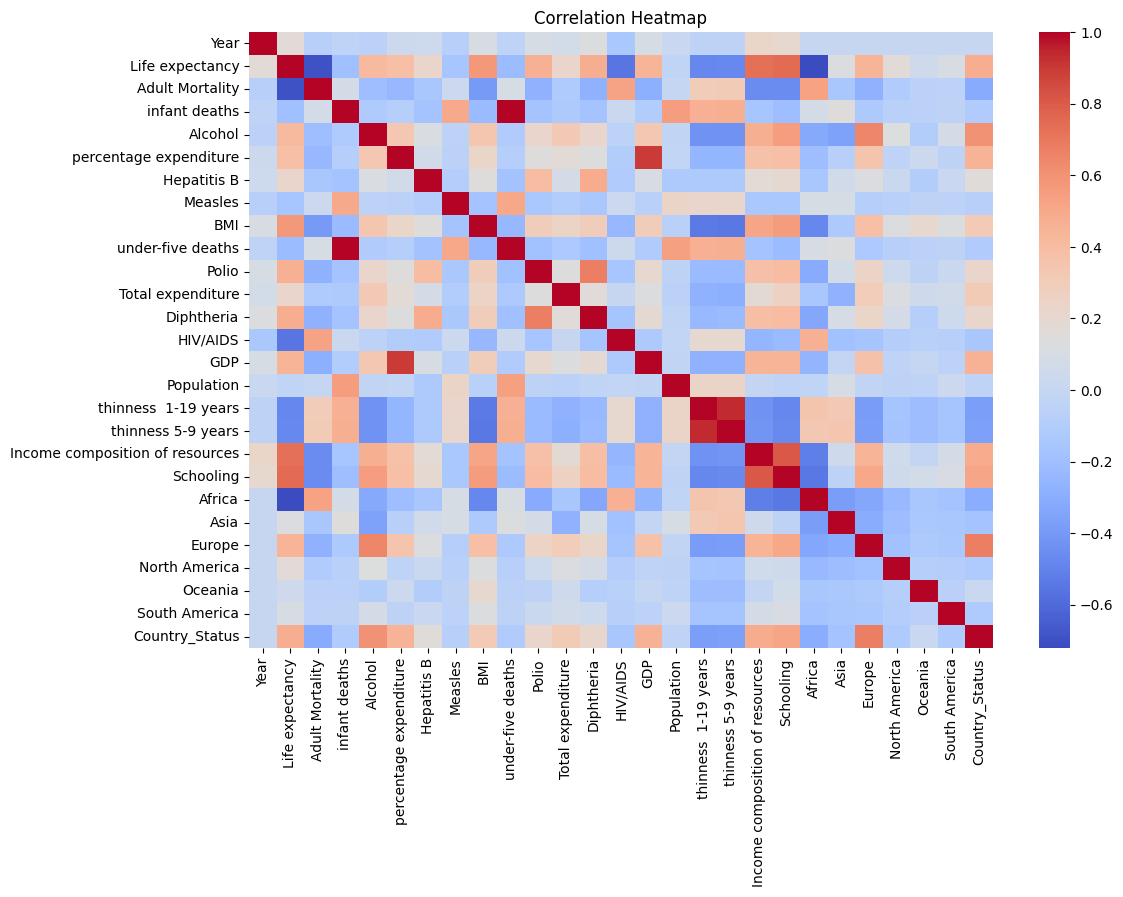

In [ ]:
plt.figure(figsize=(12,8)) 
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", annot=False) 
plt.title("Correlation Heatmap") 
plt.show()

### Feature Importance with Random Forest

To identify the most relevant predictors of Life expectancy, a Random Forest Test was trained and the feature importances were extracted. The results show that Income composition of resources, HIV/AIDS and Adult Mortality are by far the strongest factors, followed by Africa and Schooling. Most of the other variables contribute only barely.

This code for the feature importance was used from the teaching notebook.

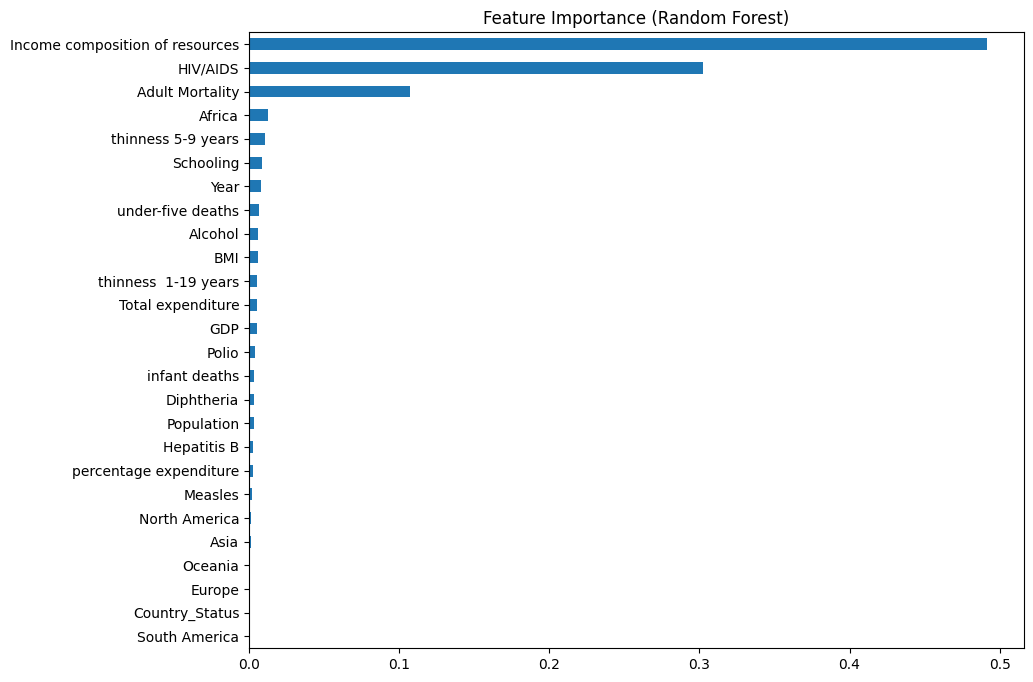

In [ ]:
rf = RandomForestRegressor(random_state=42) 
rf.fit(X, y) 
importances = pd.Series(rf.feature_importances_, index=X.columns) 
importances.sort_values(ascending=True).plot(kind="barh", 
figsize=(10,8)) 
plt.title("Feature Importance (Random Forest)") 
plt.show()

### Feature Importance with Fisher Score

As an additional method, the Fisher Score was used to rank the predictors of Life expectancy. The results show that thinness 5–9 years, alcohol and asia  achieve the highest scores, while variables like Country Status or Hepatitis B are among the least or non relevant.

This code for the fisher score was used from the teaching notebook.

<Axes: >

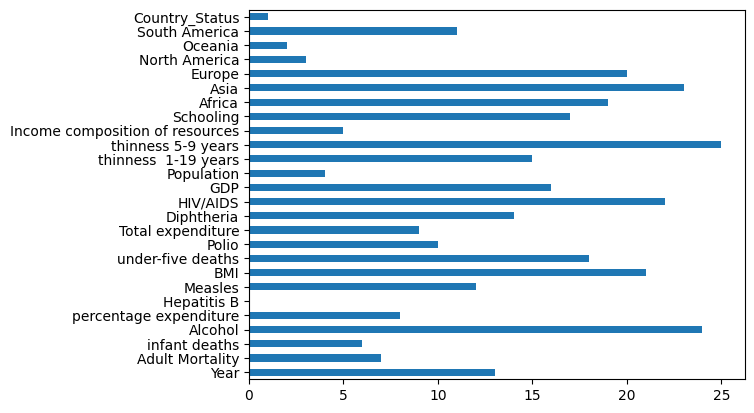

In [ ]:
ranks = fisher_score.fisher_score(X.values, y.values)

feat_importances = pd.Series(ranks, X.columns)
feat_importances.plot(kind='barh')

### Feature Importane with Chi^2 Test

To further evaluate feature relevance, the Chi^2 test was applied. The ranking highlights Population, GDP, Measles, and percentage expenditure as the strongest predictors, while variables such as Year and Oceania have very low scores.

This code for the Chi^2 test was used from the teaching notebook.

In [ ]:
X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)


chi_2_features = SelectKBest(chi2, k=len(X_cat.columns))

best_features = chi_2_features.fit(X_cat,y.astype(int))

pd.options.display.float_format = '{:.2f}'.format


df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X_cat.columns)
f_scores = pd.concat([df_columns,df_features],axis=1)
f_scores.columns = ['Features','Score']
f_scores.sort_values(by='Score',ascending=False)

,Features,Score
14,Population,26887542573.05
13,GDP,29264555.90
6,Measles,8525894.69
4,percentage expenditure,5554374.44
8,under-five deaths,144283.21
1,Adult Mortality,140047.17
2,infant deaths,95391.21
12,HIV/AIDS,25953.03
7,BMI,11130.24
11,Diphtheria,5064.44


### Feature Relevance

The feature selection analyses (Random Forest, Fisher Score, Chi^2) showed that some variables have some to no impact on predicting life expectancy (e.g., Year, Oceania, Country_Status).
For the purpose of this project I decide to keep all of these features in the dataset. This makes sure that the models are trained with the complete data structure, which is useful for my learning experience.

### Traing, Validation and Test Split
The data is split into training (70%), validation (15%), and test sets (15%). A fixed random state ensures reproducibility.

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test   = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### Neural Network Model

A neural network was implemented to predict Life expectancy. The general structure followedthe lecture material but was adapted to fit this dataset.
The model was compiled with the Adam optimizer and MSE loss.
To stabilize and optimize training, the following Keras callbacks were used:

ModelCheckpoint: https://keras.io/api/callbacks/model_checkpoint/

EarlyStopping: https://keras.io/api/callbacks/early_stopping/

ReduceLROnPlateau: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau

These callbacks were additionally optimized using GPT.Several model variants were tested, and this configuration provided the best overall performance.

In [ ]:
variable_amount = X_train.shape[1]

mc = ModelCheckpoint("best_model_lifeexp.keras", monitor="val_loss", mode="min", save_best_only=True)
es = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=7, min_lr=1e-6, verbose=1)
callbacks_opt = [mc, es, rlr]

model = keras.Sequential([
    layers.BatchNormalization(input_shape=(variable_amount,)),
    layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=0.105, l2=0.105)),
    layers.Dropout(0.1),
    layers.Dense(32, activation="relu"),
    layers.Dense(18, activation="relu"),
    layers.Dense(1)  
])


model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00125),loss="mse"
)

model.summary()

c:\Users\Mani\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 26)             │           104 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 18)             │           594 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            19 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,525 (17.68 KB)

 Trainable params: 4,473 (17.47 KB)

 Non-trainable params: 52 (208.00 B)

### Model Training

The neural network was trained with the training data and validated on a separate validation set. Training was run for up to 2000 epochs, but the applied callbacks ensured that the process stopped early once no further improvement was visible.

In [ ]:
history = model.fit(X_train, y_train,validation_data=(X_val, y_val),epochs=2000,callbacks=callbacks_opt, verbose=1)

Epoch 1/2000
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3804.6992 - val_loss: 4734810.0000 - learning_rate: 0.0012
Epoch 2/2000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 400.9871 - val_loss: 2260459.2500 - learning_rate: 0.0012
Epoch 3/2000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 159.8856 - val_loss: 445130.4375 - learning_rate: 0.0012
Epoch 4/2000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 131.6114 - val_loss: 101760.7266 - learning_rate: 0.0012
Epoch 5/2000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 115.0147 - val_loss: 20487.0527 - learning_rate: 0.0012
Epoch 6/2000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 107.9772 - val_loss: 3621.2471 - learning_rate: 0.0012
Epoch 7/2000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 99.6212 - val_loss: 496.7022 - learning_rate: 0.0012
Epoch 8/2000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 92.9228 - val_loss: 154.8982 - learning_rate: 0.0012
Epoch 9/2000
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 92.5944 - va

### Training and Validation Loss

The plot shows the development of the training loss and validation loss over the epochs. Both curves decrease significantly at the beginning, and validation loss stabilizes after a certain point. This indicates that the model was able to learn the patterns in the data.

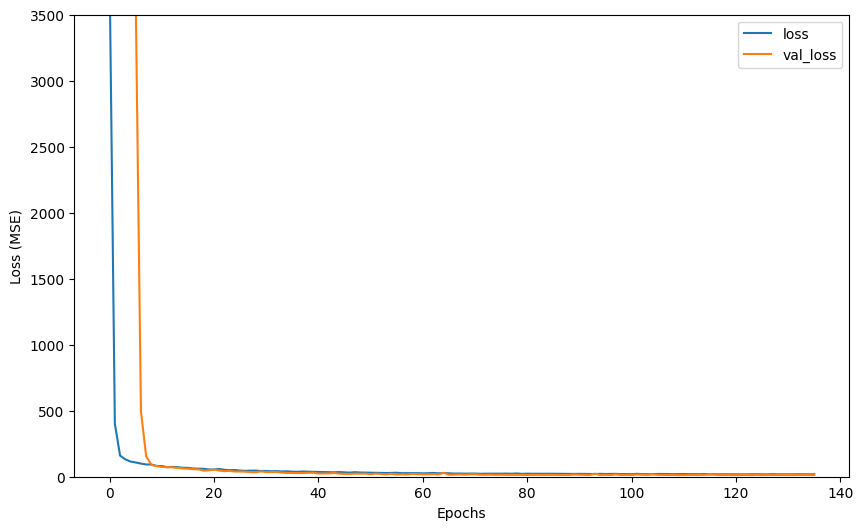

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.ylim([0, 3500]) 
plt.legend()
plt.show()

### Loading the best model

In [ ]:
model = load_model("best_model_lifeexp.keras")

### Model Evaluation
The final model achieved a training loss of 11.17 and a test loss of 13.06 (MSE).

In [ ]:
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
14.54667854309082

Train data evaluation:
12.630000114440918


### Model Prediction vs. True Values

To further evaluate the model, predictions on the test data were compared with the true target values. The results show that the predicted life expectancy values are generally very close to the actual ones, with only small differences in most cases.

In [ ]:
test_predictions = model.predict(X_test, verbose=0)
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']
pred_df

,Test True Y,Model Predictions
0,79.70,79.26
1,71.70,68.26
2,52.40,58.94
3,61.30,61.55
4,76.00,74.49
...,...,...
435,79.60,80.21
436,75.40,73.97
437,77.00,77.98
438,56.50,54.56


### Scatter-Plot

The scatter plot compares the predicted life expectancy values with the true test values. The points are closely aligned along the diagonal, which indicates a strong agreement between predictions and reality. Only a few outliers are visible, more strongly showing that the model captures the general trend very well.

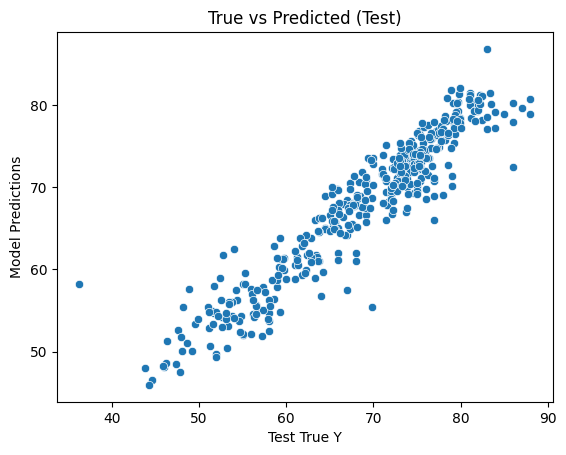

In [ ]:
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)
plt.title("True vs Predicted (Test)")
plt.show()

### Evaluation Metrics
The model achieves MAE = 2.36, RMSE = 3.28, and R^2 = 0.89, meaning predictions deviate on average by only 2 to 3 years and about 89% of the variance is explained, which is a very good outcome for this model.

In [ ]:
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "$")

print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "$^2")

print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "$")

print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
2.36 $

MSE
10.76 $^2

RMSE:
3.28 $

R-squared:
0.89

Explained variance score:
0.89


### Linear Regression Model

As a baseline, a Linear Regression model was trained on the training data and evaluated on the test set. This provides a simple benchmark to compare against the more complex neural network.

Here GPT was used to generate the Linear Regression code for comparison purposes. The correctness of the generated code was verified by ensuring it follows the standard fit() / predict() procedure from scikit-learn and produces valid outputs on both training and test sets.

In [ ]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

lin_predictions = linreg.predict(X_test)

### Linear Regression Results

The baseline linear model achieved MAE = 2.84, RMSE = 3.77, and R^2 = 0.85.
Compared to the neural network (MAE = 2.27, RMSE = 3.19, R^2 = 0.89), the linear model performs slightly worse, confirming that the neural network captures more complex relationships in the data.

In [ ]:
print("MAE")
print(round(metrics.mean_absolute_error(y_test, lin_predictions), 2), "$")

print("\nMSE")
print(round(metrics.mean_squared_error(y_test, lin_predictions), 2), "$^2")

print("\nRMSE:")
print(round(np.sqrt(metrics.mean_squared_error(y_test, lin_predictions)), 2), "$")

print("\nR-squared:")
print(round(metrics.r2_score(y_test, lin_predictions), 2))

print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, lin_predictions), 2))


MAE
2.84 $

MSE
14.22 $^2

RMSE:
3.77 $

R-squared:
0.85

Explained variance score:
0.85


### Distribution of Errors

The distribution of prediction errors (residuals) shows that most errors are centered around zero, with a roughly symmetric spread

C:\Users\Mani\AppData\Local\Temp\ipykernel_13948\3264322254.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - test_predictions))


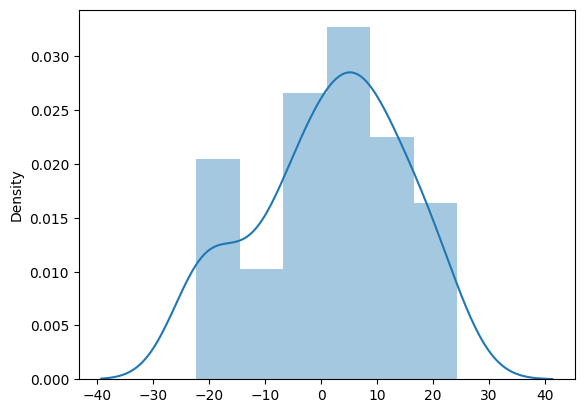

In [ ]:
sns.distplot((y_test - test_predictions))
plt.show()
plt.close()

In [ ]:
df.columns

Index(['Year', 'Life expectancy', 'Adult Mortality', 'infant deaths',
       'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI',
       'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria',
       'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years',
       'thinness 5-9 years', 'Income composition of resources', 'Schooling',
       'Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America',
       'Country_Status'],
      dtype='object')

### Example Prediction Input
To demonstrate the prediction process, a sample input row was created.

In [ ]:
tester_row = {
    "Year": 2001,
    "Adult Mortality": 600,                 
    "infant deaths": 120,                   
    "Alcohol": 0.1,                         
    "percentage expenditure": 10,           
    "Hepatitis B": 20,                    
    "Measles": 20000,                     
    "BMI": 17.0,                            
    "under-five deaths": 150,             
    "Polio": 25,                           
    "Total expenditure": 2.0,               
    "Diphtheria": 30,                       
    "HIV/AIDS": 10.0,                     
    "GDP": 500,                             
    "Population": 5000000,                
    "thinness 1-19 years": 20.0,           
    "thinness 5-9 years": 22.0,
    "Income composition of resources": 0.2, 
    "Schooling": 4.0,                       
    "Africa": 1, 
    "Asia": 0, 
    "Europe": 0,
    "North America": 0, 
    "Oceania": 0,
    "South America": 0, 
    "Country_Status": 0                     
}

tester_row = pd.DataFrame([tester_row])


In [ ]:
pred = model.predict(tester_row)
print("Predicted life expectancy in years:", pred[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted life expectancy in years: 48.96592


### Life Expectancy Prediction GUI

For demonstration purposes, a simple GUI was implemented using Tkinter. The interface allows the user to input feature values (with default examples provided) and receive a predicted life expectancy directly from the trained model.

This GUI code was generated entirely by GPT, since I had never used Tkinter before and wanted a quick and simple way to build an interface for testing predictions. The correctness was ensured by checking that all model input features are represented in the GUI and that the prediction output matches the expected format.

In [ ]:
model = load_model("best_model_lifeexp.keras")

default_values = {
    "Year": 2001,
    "Adult Mortality": 600,                 
    "infant deaths": 120,                   
    "Alcohol": 0.1,                         
    "percentage expenditure": 10,           
    "Hepatitis B": 20,                    
    "Measles": 20000,                     
    "BMI": 17.0,                            
    "under-five deaths": 150,             
    "Polio": 25,                           
    "Total expenditure": 2.0,               
    "Diphtheria": 30,                       
    "HIV/AIDS": 10.0,                     
    "GDP": 500,                             
    "Population": 5000000,                
    "thinness 1-19 years": 20.0,           
    "thinness 5-9 years": 22.0,
    "Income composition of resources": 0.2, 
    "Schooling": 4.0,                       
    "Africa": 1, 
    "Asia": 0, 
    "Europe": 0,
    "North America": 0, 
    "Oceania": 0,
    "South America": 0, 
    "Country_Status": 0                     
}

entries = {}

def predict():
    try:
        data = {f: float(entries[f].get()) for f in default_values.keys()}
        df = pd.DataFrame([data])
        pred = model.predict(df, verbose=0)[0][0]
        result_label.config(text=f"Predicted Life Expectancy: {pred:.2f} years")
    except Exception as e:
        messagebox.showerror("Error", str(e))

root = tk.Tk()
root.title("Life Expectancy Predictor")

for f, example in default_values.items():
    row = tk.Frame(root)
    lab = tk.Label(row, width=25, text=f+": ", anchor="w")
    ent = tk.Entry(row)
    ent.insert(0, str(example))  
    hint = tk.Label(row, width=15, text=f"(e.g. {example})", anchor="w", fg="grey")
    
    row.pack(side=tk.TOP, fill=tk.X, padx=5, pady=2)
    lab.pack(side=tk.LEFT)
    ent.pack(side=tk.LEFT, expand=tk.YES, fill=tk.X)
    hint.pack(side=tk.RIGHT)
    
    entries[f] = ent

predict_button = tk.Button(root, text="Predict", command=predict)
predict_button.pack(pady=10)

result_label = tk.Label(root, text="Prediction will appear here", font=("Helvetica", 12))
result_label.pack(pady=10)

root.mainloop()
